In [1]:
# Check GPU status
!nvidia-smi


Sat Nov  2 12:47:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [8]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
from sklearn.preprocessing import LabelEncoder


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
#import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns
from sklearn.manifold import TSNE


# torch geometrics
import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN
import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score
# # Grape

In [9]:
# # Grape
# from grape.datasets import get_all_available_graphs_dataframe
# from grape.datasets import get_dataset
from grape import Graph
from grape import GraphVisualizer

# # Ensmallen
# from grape.embedders import Node2VecCBOWEnsmallen, Node2VecGloVeEnsmallen, Node2VecSkipGramEnsmallen
# from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkGloVeEnsmallen, DeepWalkSkipGramEnsmallen
# from grape.embedders import WalkletsSkipGramEnsmallen, WalkletsCBOWEnsmallen, WalkletsGloVeEnsmallen
# from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
# #from grape.embedders import NetMFEnsmallen, GLEEEnsmallen, HOPEEnsmallen
from grape.embedders import TransEEnsmallen

# # TensorFlow
# from grape.embedders import SkipGramTensorFlow, CBOWTensorFlow
# from grape.embedders import FirstOrderLINETensorFlow, SecondOrderLINETensorFlow

# # KarateClub
# from grape.embedders import Role2VecKarateClub, GraRepKarateClub
# from grape.embedders import NMFADMMKarateClub, RandNEKarateClub


# # Edge prediction evaluation
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
# from grape.node_label_prediction import node_label_prediction_evaluation
# from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
# Load graph
view=5
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/content/drive/MyDrive/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [12]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [ ]:
# IMPORT METHODS

# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [ ]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [ ]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

# train_data = Data(x=nodes_x,
#                   edge_index=edge_index, edge_type=edge_type,
#                   edge_label_index=edge_index,
#                   edge_label=torch.ones(edge_index.size(1))
#                     )

# train_data = train_data.to(device)

In [ ]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

transform = RandomLinkSplit(is_undirected=False)

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
test_data = test_data.to(device)
val_data = val_data.to(device)

In [ ]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 1590078  Test:454306  Validation: 227152


In [ ]:
# Model

model = DistMult(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50, # The hidden embedding size.
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

optimizer =  optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

# ALTERNATIVE MODELS

# model_map = {
#     'transe': TransE,
#     'complex': ComplEx,
#     'distmult': DistMult,
#     'rotate': RotatE,
# }

# Proposed configurations
# optimizer_map = {
#     'transe': optim.Adam(model.parameters(), lr=0.01),
#     'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
#     'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
#     'rotate': optim.Adam(model.parameters(), lr=1e-3),
# }

In [ ]:
# Training definitions

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.9997
Epoch: 002, Loss: 0.9679
Epoch: 003, Loss: 0.8233
Epoch: 004, Loss: 0.5907
Epoch: 005, Loss: 0.4279
Epoch: 006, Loss: 0.3437
Epoch: 007, Loss: 0.2972
Epoch: 008, Loss: 0.2679
Epoch: 009, Loss: 0.2487
Epoch: 010, Loss: 0.2344
Epoch: 011, Loss: 0.2234
Epoch: 012, Loss: 0.2151
Epoch: 013, Loss: 0.2072
Epoch: 014, Loss: 0.2009
Epoch: 015, Loss: 0.1953
Epoch: 016, Loss: 0.1900
Epoch: 017, Loss: 0.1848
Epoch: 018, Loss: 0.1806
Epoch: 019, Loss: 0.1768
Epoch: 020, Loss: 0.1727
Epoch: 021, Loss: 0.1686
Epoch: 022, Loss: 0.1657
Epoch: 023, Loss: 0.1618
Epoch: 024, Loss: 0.1585
Epoch: 025, Loss: 0.1565


100%|██████████| 795039/795039 [18:26<00:00, 718.52it/s]


Epoch: 025, Val Mean Rank: 4871.56, Val MRR: 0.0186, Val Hits@10: 0.0347


In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.1340
Epoch: 002, Loss: 0.1330
Epoch: 003, Loss: 0.1321
Epoch: 004, Loss: 0.1298
Epoch: 005, Loss: 0.1300
Epoch: 006, Loss: 0.1287
Epoch: 007, Loss: 0.1284
Epoch: 008, Loss: 0.1271
Epoch: 009, Loss: 0.1261
Epoch: 010, Loss: 0.1249
Epoch: 011, Loss: 0.1245
Epoch: 012, Loss: 0.1238
Epoch: 013, Loss: 0.1225
Epoch: 014, Loss: 0.1227
Epoch: 015, Loss: 0.1219
Epoch: 016, Loss: 0.1209
Epoch: 017, Loss: 0.1214
Epoch: 018, Loss: 0.1201
Epoch: 019, Loss: 0.1202
Epoch: 020, Loss: 0.1187
Epoch: 021, Loss: 0.1193
Epoch: 022, Loss: 0.1188
Epoch: 023, Loss: 0.1179
Epoch: 024, Loss: 0.1174
Epoch: 025, Loss: 0.1172


100%|██████████| 795039/795039 [18:20<00:00, 722.58it/s]


Epoch: 025, Val Mean Rank: 4412.15, Val MRR: 0.0176, Val Hits@10: 0.0315


In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.1167
Epoch: 002, Loss: 0.1159
Epoch: 003, Loss: 0.1154
Epoch: 004, Loss: 0.1154
Epoch: 005, Loss: 0.1150
Epoch: 006, Loss: 0.1146
Epoch: 007, Loss: 0.1147
Epoch: 008, Loss: 0.1140
Epoch: 009, Loss: 0.1133
Epoch: 010, Loss: 0.1126
Epoch: 011, Loss: 0.1126
Epoch: 012, Loss: 0.1123
Epoch: 013, Loss: 0.1124
Epoch: 014, Loss: 0.1113
Epoch: 015, Loss: 0.1114
Epoch: 016, Loss: 0.1110
Epoch: 017, Loss: 0.1108
Epoch: 018, Loss: 0.1098
Epoch: 019, Loss: 0.1104
Epoch: 020, Loss: 0.1091
Epoch: 021, Loss: 0.1093
Epoch: 022, Loss: 0.1082
Epoch: 023, Loss: 0.1087
Epoch: 024, Loss: 0.1079
Epoch: 025, Loss: 0.1076


100%|██████████| 795039/795039 [18:25<00:00, 719.01it/s]


Epoch: 025, Val Mean Rank: 4171.58, Val MRR: 0.0172, Val Hits@10: 0.0314


In [ ]:
# Testing
rank, mrr, hits_at_10 = test(test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 908615/908615 [21:01<00:00, 720.09it/s]


Test Mean Rank: 4473.15, Test MRR: 0.0169, Test Hits@10: 0.0311


In [ ]:
## EXTERNAL TEST SETS

## VIEW 0-2
#test_sets = ['miRNA-disease2bepred']
#test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.txt", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test-.txt",names=["subject","predicate","object"], sep='\t')

In [ ]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 125], [True, 31354]]


In [ ]:
rank, mrr, hits_at_10 = test(external_test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 31354/31354 [00:43<00:00, 713.24it/s]

Test Mean Rank: 1116.13, Test MRR: 0.0712, Test Hits@10: 0.1504


In [ ]:
node_embedding = pd.DataFrame(model.node_emb.weight.cpu().detach().numpy())

label_encoder = LabelEncoder()
node_types = label_encoder.fit_transform(list(nodes_df.type))
node_embedding.index = nodes_df
len(node_embedding)

85299

In [ ]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
"(<http://www.ncbi.nlm.nih.gov/gene/1163>, Gene)",0.086523,-0.082622,0.087160,0.082794,0.081549,-0.076981,0.084216,0.082755,0.083187,0.083685,...,0.086717,-0.081812,-0.086186,-4.905203e-39,-0.089813,0.083741,-0.083260,0.084920,0.082403,-0.083026
"(<http://purl.obolibrary.org/obo/GO_1902115>, GO)",0.038269,0.162933,-0.164078,-0.161863,0.052260,-0.076120,0.055199,-0.159365,-0.155605,0.025556,...,-0.006778,0.158912,-0.018795,4.916950e-39,-0.045649,0.036565,0.160243,0.054811,0.008783,-0.039176
"(<http://purl.obolibrary.org/obo/MONDO_0009301>, Disease)",0.066323,-0.019304,0.023650,0.017694,0.067172,-0.096256,0.081758,0.021024,0.015543,0.065855,...,0.064444,-0.013724,-0.076230,-4.910000e-39,-0.086191,0.059449,-0.012946,0.074978,0.072001,-0.062447
"(<http://www.ncbi.nlm.nih.gov/gene/2692>, Gene)",0.103136,-0.058880,0.053572,0.062175,0.110026,-0.109476,0.104966,0.054831,0.061905,0.108188,...,0.102186,-0.055133,-0.112721,-4.918458e-39,-0.110907,0.101005,-0.052373,0.102954,0.098930,-0.100899
"(<http://purl.obolibrary.org/obo/MONDO_0000535>, Disease)",-0.068226,-0.027022,0.027034,0.035490,-0.047942,0.074119,-0.053673,0.050152,0.038435,-0.062583,...,-0.070398,-0.038620,0.055402,-4.914173e-39,0.055703,-0.062685,-0.039449,-0.061220,-0.058897,0.084829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(<http://purl.obolibrary.org/obo/MONDO_0012718>, Disease)",-0.094863,-0.031074,0.039833,0.016069,-0.097527,0.126922,-0.105237,0.027979,0.029464,-0.105460,...,-0.105784,-0.019225,0.098294,4.916960e-39,0.121712,-0.082627,-0.030023,-0.110817,-0.093391,0.092046
"(<https://www.mirbase.org/mature/MIMAT0002841>, miRNA)",-0.185814,-0.244815,0.174842,0.233625,-0.199075,0.153954,-0.174910,0.209911,0.207139,-0.190277,...,-0.179145,-0.231349,0.200156,4.907591e-39,0.196616,-0.182685,-0.234127,-0.185855,-0.202999,0.191286
"(<http://purl.obolibrary.org/obo/GO_0102175>, GO)",0.093918,0.072119,-0.069062,-0.067018,0.103998,-0.122854,0.104434,-0.065113,-0.070912,0.094527,...,0.092340,0.070270,-0.098958,-4.914673e-39,-0.089680,0.088535,0.062716,0.100407,0.094669,-0.090843
"(<http://purl.obolibrary.org/obo/HP_0500107>, Phenotype)",-0.066770,-0.037830,0.044300,0.035719,-0.061615,0.070356,-0.062349,0.036145,0.032877,-0.068192,...,-0.065639,-0.033150,0.066336,-4.909553e-39,0.075269,-0.061883,-0.043039,-0.064738,-0.062787,0.066948


In [ ]:
!ls -lh


total 8.0K
drwx------ 5 root root 4.0K Jul 28 09:16 drive
drwxr-xr-x 1 root root 4.0K Jul 25 13:21 sample_data


In [ ]:
node_embedding.to_csv('node_embeddings.csv', header=False, index=True, sep=',')

In [ ]:
node_embedding = pd.read_csv('/content/drive/MyDrive/models_thesis/mayank/ST_TRUE/view5_dismult_node_embeddings.csv', header= None)

In [ ]:
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
node_embedding.set_index(node_embedding.columns[0], inplace=True)

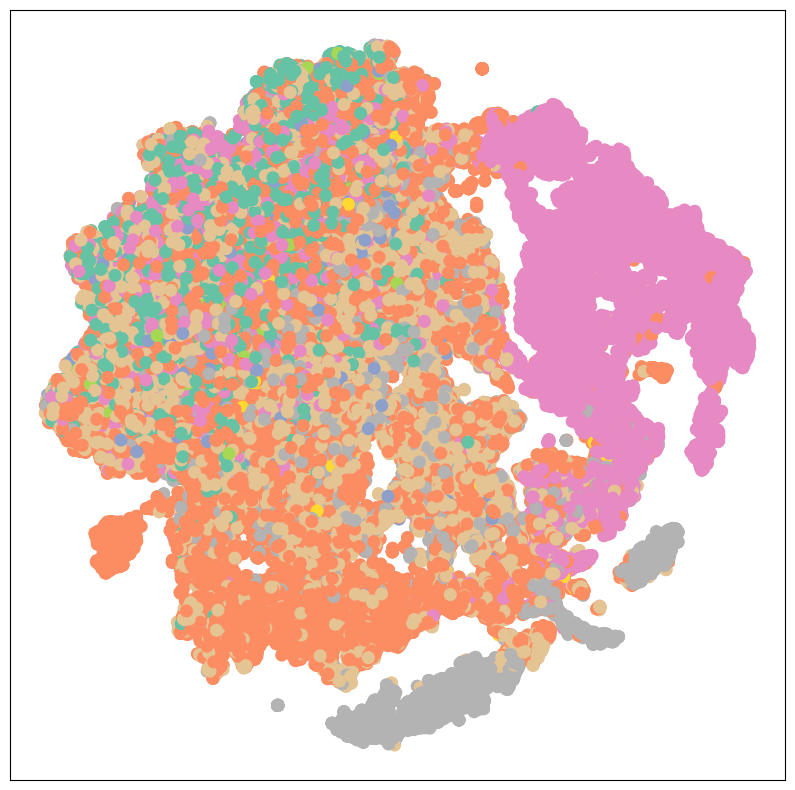

In [ ]:
visualize(node_embedding.values,node_types)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

In [ ]:
label_encoder = LabelEncoder()
node_types = label_encoder.fit_transform(list(nodes_df.type))

<ipython-input-15-33f9d704249d>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


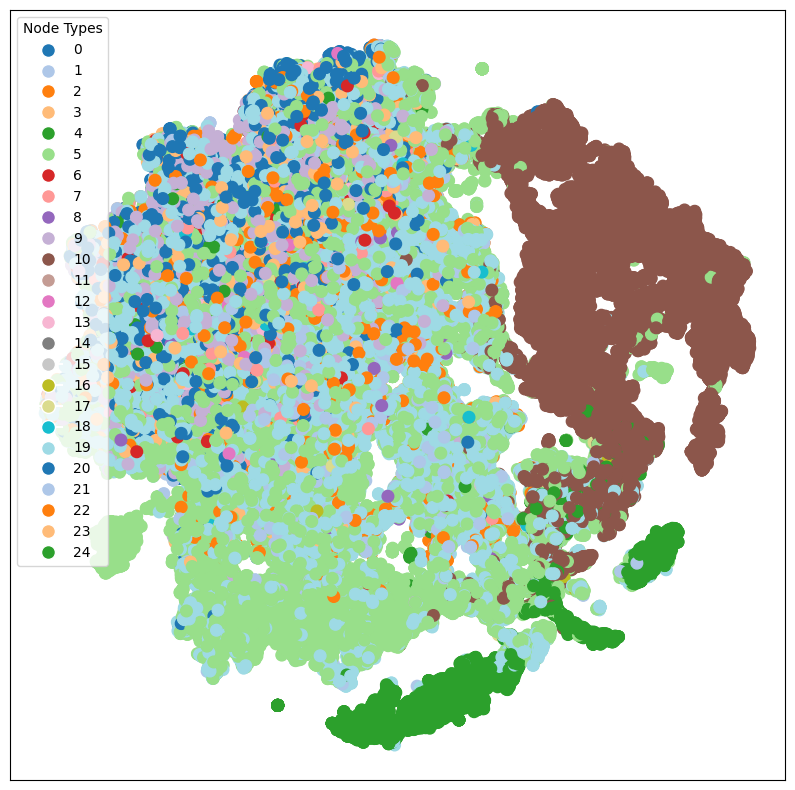

In [ ]:
visualize(node_embeddings.values, node_types)

In [ ]:
nodes_df

,name,type
0,<http://www.ncbi.nlm.nih.gov/gene/1163>,Gene
1,<http://purl.obolibrary.org/obo/GO_1902115>,GO
2,<http://purl.obolibrary.org/obo/MONDO_0009301>,Disease
3,<http://www.ncbi.nlm.nih.gov/gene/2692>,Gene
4,<http://purl.obolibrary.org/obo/MONDO_0000535>,Disease
...,...,...
85294,<http://purl.obolibrary.org/obo/UBERON_0035110>,Anatomy
85295,<https://www.mirbase.org/mature/MIMAT0002841>,miRNA
85296,<http://purl.obolibrary.org/obo/CHEBI_36834>,Chemical
85297,<http://purl.obolibrary.org/obo/HP_0500107>,Phenotype


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = node_embedding.values
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.6640
Precision: 0.6706
Recall: 0.6640


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

selected_classes = ['miRNA', 'Gene', 'Disease']

filtered_embeddings = []
filtered_labels = []


for class_label in selected_classes:

    class_indices = nodes_df[nodes_df['type'] == class_label].index


    class_embeddings = node_embedding.iloc[class_indices, 1:].values  # Skip the first column with identifiers

    # Append the filtered embeddings and labels
    filtered_embeddings.append(class_embeddings)
    filtered_labels.extend([class_label] * len(class_embeddings))


X_filtered = np.vstack(filtered_embeddings)

# Encode the labels
le = LabelEncoder()
y_filtered = le.fit_transform(filtered_labels)  # Convert the labels into numerical form


X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

precision_per_class = precision_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))
recall_per_class = recall_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))

for i, class_label in enumerate(le.classes_):
    if class_label in selected_classes:
        print(f"Class: {class_label}")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")


Accuracy: 0.9786
Precision: 0.9787
Recall: 0.9786
Class: Disease
  Precision: 0.9848
  Recall: 0.9873
Class: Gene
  Precision: 0.9689
  Recall: 0.9819
Class: miRNA
  Precision: 0.9862
  Recall: 0.9246


In [13]:
node_embeddings = pd.read_csv('/content/drive/MyDrive/models_thesis/mayank/NODE_EMBEDDINGS_COMPLEX_DISTMULT/view5_distmult_node_embeddings.csv', header= None)

In [14]:
node_embeddings.set_index(node_embeddings.columns[0], inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

true_labels = nodes_df['type']

# Prepare the features and labels
X = node_embeddings.values
y = true_labels

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6638139898397811
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                           precision    recall  f1-score   support

                  Anatomy       0.40      0.54      0.46      1851
                     Cell       1.00      0.03      0.05       386
                 Chemical       0.58      0.06      0.11       598
               Chromosome       1.00      0.14      0.24        94
                  Disease       0.63      0.77      0.69      7237
              Environment       0.00      0.00      0.00       124
   Environmental exposure       1.00      0.02      0.03       121
                     Food       0.00      0.00      0.00        48
                       GO       0.39      0.21      0.28      1237
                     Gene       0.96      0.98      0.97      5490
  General medical science       0.00      0.00      0.00         1
Human developmental stage       0.00      0.00      0.00        26
           Medical action       0.00      0.00      0.00        36
           Mental disease       0.00      0.00      0.00     

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the labels
true_labels = nodes_df['type']
X =  node_embedding.values

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(true_labels)  # Convert the labels into numerical form

class_distribution = np.bincount(y)
print("Class distribution:", dict(zip(le.classes_, class_distribution)))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42,  class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1-score for each class (node type)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")

for i, class_label in enumerate(le.classes_):
    try:
        precision_class = precision_score(y_test, y_pred, labels=[i], average='macro')
        recall_class = recall_score(y_test, y_pred, labels=[i], average='macro')
        f1_class = f1_score(y_test, y_pred, labels=[i], average='macro')
        print(f"Class: {class_label}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1[i]:.4f}")
    except IndexError:
        print(f"Class: {class_label}")
        print("  Precision: 0.0000 (No predictions for this class)")
        print("  Recall: 0.0000")
        print("  F1 Score: 0.0000")

Class distribution: {'Anatomy': 6129, 'Basic formal': 1, 'Cell': 1272, 'Chemical': 2000, 'Chromosome': 310, 'Disease': 23966, 'Environment': 446, 'Environmental exposure': 419, 'Food': 172, 'GO': 4071, 'Gene': 18341, 'General medical science': 6, 'Human developmental stage': 72, 'Medical action': 114, 'Mental disease': 12, 'Mental functioning': 14, 'Mouse pathology': 75, 'NCI thesaurus': 84, 'Neuro behaviour': 153, 'Phenotype': 18488, 'Protein': 205, 'Sequence': 2386, 'Species': 1766, 'Vaccine': 1, 'miRNA': 4796}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined

Overall Accuracy: 0.6555
Class: Anatomy
  Precision: 0.4078
  Recall: 0.4625
  F1 Score: 0.4334
Class: Basic formal
  Precision: 0.7333
  Recall: 0.0285
  F1 Score: 0.0549
Class: Cell
  Precision: 0.5714
  Recall: 0.0535
  F1 Score: 0.0979
Class: Chemical
  Precision: 0.9688
  Recall: 0.3298
  F1 Score: 0.4921
Class: Chromosome
  Precision: 0.6180
  Recall: 0.7593
  F1 Score: 0.6814
Class: Disease
  Precision: 0.6667
  Recall: 0.0161
  F1 Score: 0.0315
Class: Environment
  Precision: 0.8333
  Recall: 0.0413
  F1 Score: 0.0787
Class: Environmental exposure
  Precision: 0.5000
  Recall: 0.0208
  F1 Score: 0.0400
Class: Food
  Precision: 0.4280
  Recall: 0.1827
  F1 Score: 0.2561
Class: GO
  Precision: 0.9472
  Recall: 0.9796
  F1 Score: 0.9631
Class: Gene
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: General medical science
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Human developmental stage
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Clas

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

Class: Mental functioning
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Mouse pathology
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: NCI thesaurus
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Neuro behaviour
  Precision: 0.4909
  Recall: 0.6115
  F1 Score: 0.5446
Class: Phenotype
  Precision: 0.9333
  Recall: 0.2295
  F1 Score: 0.3684
Class: Protein
  Precision: 0.9615
  Recall: 0.0372
  F1 Score: 0.0716
Class: Sequence
  Precision: 0.7037
  Recall: 0.0339
  F1 Score: 0.0646


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and bei

Class: Species
  Precision: 0.9718
  Recall: 0.9180
  F1 Score: 0.9441
Class: Vaccine
Class: Vaccine
  Precision: 0.0000 (No predictions for this class)
  Recall: 0.0000
  F1 Score: 0.0000
Class: miRNA
Class: miRNA
  Precision: 0.0000 (No predictions for this class)
  Recall: 0.0000
  F1 Score: 0.0000


In [ ]:
node_embeddings = pd.read_csv('/content/drive/MyDrive/models_thesis/mayank/view5_dismult_node_embeddings.csv', header= None)

In [ ]:
node_embeddings

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,"('<http://www.ncbi.nlm.nih.gov/gene/1163>', 'G...",0.086523,-0.082622,0.087160,0.082794,0.081549,-0.076981,0.084216,0.082755,0.083187,...,0.086717,-0.081812,-0.086186,-4.905203e-39,-0.089813,0.083741,-0.083260,0.084920,0.082403,-0.083026
1,('<http://purl.obolibrary.org/obo/GO_1902115>'...,0.038269,0.162933,-0.164078,-0.161863,0.052260,-0.076120,0.055199,-0.159365,-0.155605,...,-0.006778,0.158912,-0.018795,4.916950e-39,-0.045649,0.036565,0.160243,0.054811,0.008783,-0.039176
2,('<http://purl.obolibrary.org/obo/MONDO_000930...,0.066323,-0.019304,0.023650,0.017694,0.067172,-0.096256,0.081758,0.021024,0.015543,...,0.064444,-0.013724,-0.076230,-4.910000e-39,-0.086191,0.059449,-0.012946,0.074978,0.072001,-0.062447
3,"('<http://www.ncbi.nlm.nih.gov/gene/2692>', 'G...",0.103136,-0.058880,0.053572,0.062175,0.110026,-0.109476,0.104966,0.054831,0.061905,...,0.102186,-0.055133,-0.112721,-4.918458e-39,-0.110907,0.101005,-0.052373,0.102954,0.098930,-0.100899
4,('<http://purl.obolibrary.org/obo/MONDO_000053...,-0.068226,-0.027022,0.027034,0.035490,-0.047942,0.074119,-0.053673,0.050152,0.038435,...,-0.070398,-0.038620,0.055402,-4.914173e-39,0.055704,-0.062685,-0.039449,-0.061220,-0.058897,0.084829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85294,('<http://purl.obolibrary.org/obo/MONDO_001271...,-0.094863,-0.031074,0.039833,0.016069,-0.097527,0.126922,-0.105237,0.027979,0.029464,...,-0.105784,-0.019225,0.098294,4.916960e-39,0.121713,-0.082627,-0.030023,-0.110817,-0.093391,0.092046
85295,('<https://www.mirbase.org/mature/MIMAT0002841...,-0.185814,-0.244815,0.174842,0.233625,-0.199075,0.153954,-0.174910,0.209911,0.207139,...,-0.179145,-0.231349,0.200156,4.907591e-39,0.196616,-0.182685,-0.234127,-0.185855,-0.202999,0.191286
85296,('<http://purl.obolibrary.org/obo/GO_0102175>'...,0.093918,0.072119,-0.069062,-0.067018,0.103998,-0.122854,0.104434,-0.065113,-0.070912,...,0.092340,0.070270,-0.098958,-4.914673e-39,-0.089680,0.088535,0.062716,0.100407,0.094669,-0.090843
85297,('<http://purl.obolibrary.org/obo/HP_0500107>'...,-0.066770,-0.037830,0.044300,0.035719,-0.061615,0.070356,-0.062349,0.036145,0.032877,...,-0.065639,-0.033150,0.066336,-4.909553e-39,0.075269,-0.061883,-0.043039,-0.064738,-0.062787,0.066948


In [ ]:
node_embeddings.set_index(node_embeddings.columns[0], inplace=True)

In [ ]:
node_embeddings.values

array([[ 0.08652326, -0.08262152,  0.08715952, ...,  0.08491962,
         0.08240335, -0.08302619],
       [ 0.03826887,  0.16293316, -0.16407794, ...,  0.05481077,
         0.00878261, -0.03917645],
       [ 0.06632311, -0.01930393,  0.02364991, ...,  0.07497841,
         0.07200138, -0.06244701],
       ...,
       [ 0.09391797,  0.072119  , -0.06906202, ...,  0.10040697,
         0.09466891, -0.0908431 ],
       [-0.06676953, -0.03782969,  0.04429963, ..., -0.06473782,
        -0.06278747,  0.06694806],
       [-0.01265403, -0.0832943 ,  0.0881203 , ..., -0.0297525 ,
        -0.009255  ,  0.02419105]])

In [15]:
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [16]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [ ]:
# Assuming node_embedding index is a tuple of (URI, type)
node_embeddings.index = [name[0] for name in node_embeddings.index]

In [ ]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=node_embeddings.values,  # Use simplified embedding features
    smoke_test=False,
    enable_cache=False
)

Evaluating on VIEW5_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_csv(filename)

In [ ]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,precision,accuracy,prevalence_threshold,miss_rate,diagnostic_odds_ratio,recall,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.542593,0.575605,0.478665,0.036867,6.051545,0.963133,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.543089,0.576521,0.478415,0.035544,6.306385,0.964456,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.542067,0.574761,0.478929,0.036643,6.013981,0.963357,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.542478,0.575568,0.478722,0.034941,6.314310,0.965059,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.542713,0.575801,0.478604,0.036873,6.066401,0.963127,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.542564,0.575616,0.478680,0.036108,6.153905,0.963892,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.541296,0.573318,0.479317,0.038969,5.620462,0.961031,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.541563,0.573884,0.479182,0.037296,5.861726,0.962704,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.542903,0.576113,0.478509,0.036860,6.092723,0.963140,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.543162,0.576644,0.478378,0.035496,6.323484,0.964504,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


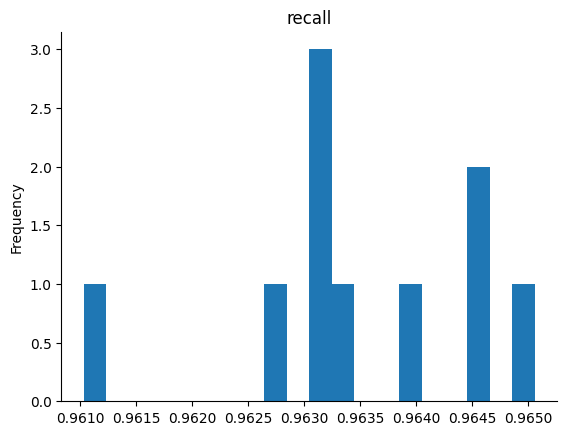

In [ ]:
from matplotlib import pyplot as plt
results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

In [20]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[DecisionTreeEdgePrediction()],
    number_of_holdouts=5,
    node_features=node_embeddings.values,  # Use simplified embedding features
    smoke_test=False
)

Evaluating on VIEW5_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

In [21]:
results = evaluation
filename = "results_"+view_name+"DesicionTree_V5Distmult.csv"
results.to_csv(filename)

In [22]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,balanced_accuracy,fall_out,recall,informedness,accuracy,miss_rate,...,"(model_parameters, criterion)","(model_parameters, splitter)","(model_parameters, max_depth)","(model_parameters, min_samples_split)","(model_parameters, min_samples_leaf)","(model_parameters, min_weight_fraction_leaf)","(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, ccp_alpha)"
0,train,0.800001,1.0,True,0.575325,0.810431,0.961081,0.150650,0.575325,0.038919,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.577278,0.810036,0.964592,0.154557,0.577278,0.035408,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.574901,0.805706,0.955508,0.149802,0.574901,0.044492,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.576508,0.806390,0.959406,0.153016,0.576508,0.040594,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.574054,0.802223,0.950331,0.148108,0.574054,0.049669,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.574364,0.803388,0.952116,0.148728,0.574364,0.047884,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.578329,0.803096,0.959753,0.156657,0.578329,0.040247,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.579948,0.803357,0.963254,0.159897,0.579948,0.036746,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.575488,0.812906,0.963882,0.150976,0.575488,0.036118,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.576459,0.813100,0.966018,0.152919,0.576459,0.033982,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0


In [23]:
# Separate train and test results
train_results = evaluation[evaluation['evaluation_mode'] == 'train']
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Function to compute mean metrics for a given evaluation mode
def compute_mean_metrics(data):
    results = []
    for holdout in data['holdout_number'].unique():
        holdout_data = data[data['holdout_number'] == holdout]

        # Calculate mean values for metrics
        auc_score = holdout_data['auroc'].mean()
        precision = holdout_data['precision'].mean()
        recall = holdout_data['recall'].mean()
        f1_score = holdout_data['f1_score'].mean()
        accuracy = holdout_data['accuracy'].mean()  # Assuming 'accuracy' column exists

        # Append results for this holdout
        results.append({
            'Holdout': holdout,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Accuracy': accuracy
        })

    # Convert to DataFrame
    return pd.DataFrame(results)

# Compute metrics for train and test
train_metrics_df = compute_mean_metrics(train_results)
test_metrics_df = compute_mean_metrics(test_results)

# Calculate overall mean for train and test
overall_train_mean = train_metrics_df.mean(numeric_only=True)
overall_test_mean = test_metrics_df.mean(numeric_only=True)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Evaluation Mode': ['Train', 'Test'],
    'AUC': [overall_train_mean['AUC'], overall_test_mean['AUC']],
    'Precision': [overall_train_mean['Precision'], overall_test_mean['Precision']],
    'Recall': [overall_train_mean['Recall'], overall_test_mean['Recall']],
    'F1 Score': [overall_train_mean['F1 Score'], overall_test_mean['F1 Score']],
    'Accuracy': [overall_train_mean['Accuracy'], overall_test_mean['Accuracy']]
})

# Display the summary of mean metrics
print(summary_df)

  Evaluation Mode       AUC  Precision    Recall  F1 Score  Accuracy
0           Train  0.653985   0.542844  0.958111  0.693029  0.575619
1            Test  0.693886   0.543493  0.961077  0.694333  0.576912
